# **Song recommendation algorithm**

Personalized music recommendation system using the Alternating Least Squares (ALS) algorithm.

In [118]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import implicit
import pickle
from scipy.sparse import csr_matrix
from tempfile import TemporaryDirectory
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [51]:
def load_data(dataset_name, path):
    return kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        dataset_name,
        path,
    )

In [53]:
def load_spotify_data():
    high_popularity = load_data("solomonameh/spotify-music-dataset", "high_popularity_spotify_data.csv")
    low_popularity = load_data("solomonameh/spotify-music-dataset", "low_popularity_spotify_data.csv")
    
    # Add a popularity category label to datasets
    high_popularity['popularity_category'] = 'high'
    low_popularity['popularity_category'] = 'low'
    
    # Combine the datasets
    combined_data = pd.concat([high_popularity, low_popularity], ignore_index=True)
    
    print(f"Total songs in dataset: {len(combined_data)}")
    print(f"High popularity songs: {len(high_popularity)}")
    print(f"Low popularity songs: {len(low_popularity)}")
    
    return combined_data

spotify_data = load_spotify_data()

pd.set_option('display.max_columns', None)
spotify_data.head()

/tmp/ipykernel_110948/3988642003.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  return kagglehub.load_dataset(
/tmp/ipykernel_110948/3988642003.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  return kagglehub.load_dataset(


Total songs in dataset: 4831
High popularity songs: 1686
Low popularity songs: 3145


,energy,tempo,danceability,playlist_genre,loudness,liveness,valence,track_artist,time_signature,speechiness,track_popularity,track_href,uri,track_album_name,playlist_name,analysis_url,track_id,track_name,track_album_release_date,instrumentalness,track_album_id,mode,key,duration_ms,acousticness,id,playlist_subgenre,type,playlist_id,popularity_category
0,0.592,157.969,0.521,pop,-7.777,0.122,0.535,"Lady Gaga, Bruno Mars",3.0,0.0304,100,https://api.spotify.com/v1/tracks/2plbrEY59Iik...,spotify:track:2plbrEY59IikOBgBGLjaoe,Die With A Smile,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/2plb...,2plbrEY59IikOBgBGLjaoe,Die With A Smile,2024-08-16,0.0000,10FLjwfpbxLmW8c25Xyc2N,0.0,6.0,251668.0,0.3080,2plbrEY59IikOBgBGLjaoe,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
1,0.507,104.978,0.747,pop,-10.171,0.117,0.438,Billie Eilish,4.0,0.0358,97,https://api.spotify.com/v1/tracks/6dOtVTDdiauQ...,spotify:track:6dOtVTDdiauQNBQEDOtlAB,HIT ME HARD AND SOFT,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/6dOt...,6dOtVTDdiauQNBQEDOtlAB,BIRDS OF A FEATHER,2024-05-17,0.0608,7aJuG4TFXa2hmE4z1yxc3n,1.0,2.0,210373.0,0.2000,6dOtVTDdiauQNBQEDOtlAB,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
2,0.808,108.548,0.554,pop,-4.169,0.159,0.372,Gracie Abrams,4.0,0.0368,93,https://api.spotify.com/v1/tracks/7ne4VBA60CxG...,spotify:track:7ne4VBA60CxGM75vw0EYad,The Secret of Us (Deluxe),Today's Top Hits,https://api.spotify.com/v1/audio-analysis/7ne4...,7ne4VBA60CxGM75vw0EYad,That’s So True,2024-10-18,0.0000,0hBRqPYPXhr1RkTDG3n4Mk,1.0,1.0,166300.0,0.2140,7ne4VBA60CxGM75vw0EYad,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
3,0.910,112.966,0.670,pop,-4.070,0.304,0.786,Sabrina Carpenter,4.0,0.0634,81,https://api.spotify.com/v1/tracks/1d7Ptw3qYcfp...,spotify:track:1d7Ptw3qYcfpdLNL5REhtJ,Short n' Sweet,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/1d7P...,1d7Ptw3qYcfpdLNL5REhtJ,Taste,2024-08-23,0.0000,4B4Elma4nNDUyl6D5PvQkj,0.0,0.0,157280.0,0.0939,1d7Ptw3qYcfpdLNL5REhtJ,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high
4,0.783,149.027,0.777,pop,-4.477,0.355,0.939,"ROSÉ, Bruno Mars",4.0,0.2600,98,https://api.spotify.com/v1/tracks/5vNRhkKd0yEA...,spotify:track:5vNRhkKd0yEAg8suGBpjeY,APT.,Today's Top Hits,https://api.spotify.com/v1/audio-analysis/5vNR...,5vNRhkKd0yEAg8suGBpjeY,APT.,2024-10-18,0.0000,2IYQwwgxgOIn7t3iF6ufFD,0.0,0.0,169917.0,0.0283,5vNRhkKd0yEAg8suGBpjeY,mainstream,audio_features,37i9dQZF1DXcBWIGoYBM5M,high


In [60]:
pyspark_spotify_data = load_data("kapturovalexander/spotify-data-from-pyspark-course", "spotify-data.csv")

/tmp/ipykernel_110948/3988642003.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  return kagglehub.load_dataset(


In [65]:
pyspark_spotify_data.head()

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],158648,1928,1928,0.995,0.708,0.1950,0.563,0.1510,-12.428,0.0506,118.469,0.7790,1,10,0,0
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",282133,1928,1928,0.994,0.379,0.0135,0.901,0.0763,-28.454,0.0462,83.972,0.0767,1,8,0,0
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],104300,1928,1928,0.604,0.749,0.2200,0.000,0.1190,-19.924,0.9290,107.177,0.8800,0,5,0,0
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],180760,9/25/28,1928,0.995,0.781,0.1300,0.887,0.1110,-14.734,0.0926,108.003,0.7200,0,1,0,0
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",687733,1928,1928,0.990,0.210,0.2040,0.908,0.0980,-16.829,0.0424,62.149,0.0693,1,11,1,0


In [93]:
# row where id 6dOtVTDdiauQNBQEDOtlAB
pyspark_spotify_data[pyspark_spotify_data['name'] == 'Layla']


,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
6829,1KDsONFxp3YtnJTaLeWFIi,Layla,['Derek & The Dominos'],428387,10/9/07,2007,0.513,0.405,0.799,0.3750,0.221,-6.615,0.0635,113.991,0.274,1,5,43,0
93937,3gce83TvahSnFHFtCqbe4R,Layla,"['Derek & The Dominos', 'Eric Clapton']",424333,1/1/82,1982,0.440,0.404,0.749,0.4700,0.340,-10.300,0.0564,115.428,0.461,1,1,51,0
139458,7Lh4K1i0C3FWWNQ4ZvFVIC,Layla,"['Derek & The Dominos', 'Duane Allman']",427674,11/1/72,1972,0.189,0.469,0.779,0.1410,0.325,-8.548,0.0445,115.425,0.375,1,1,38,0
156776,0e4os6wHr1jbFn4yPtSEOe,Layla,"['Eric Clapton', 'Jon Astley', 'Andy Macpherson']",385637,1973,1973,0.174,0.488,0.676,0.0262,0.960,-10.610,0.0348,115.519,0.539,1,0,30,0


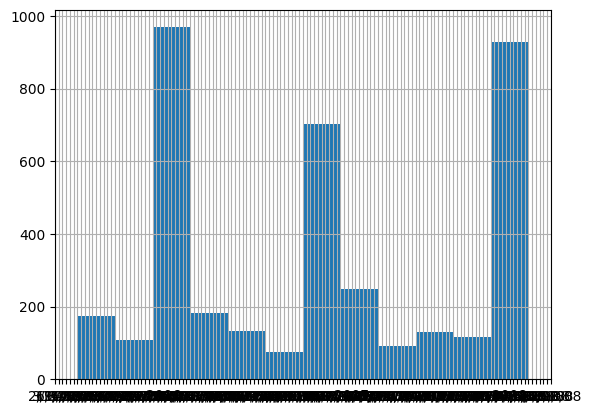

In [73]:
# release date year distribution
pyspark_spotify_data['release_date'].hist(bins=range(1900, 2025, 10))
plt.show()


In [95]:
def integrate_additional_spotify_data(original_data, new_dataset_name, new_file_path):
    print(f"Loading additional data from {new_file_path}...")
    
    new_data = load_data(new_dataset_name, new_file_path)
    print(f"Loaded {len(new_data)} tracks from additional dataset")
    
    # Create a copy to modify
    processed_new_data = new_data.copy()
    
    # Map column names from new dataset to match original dataset structure
    column_mapping = {
        'id': 'track_id',
        'name': 'track_name',
        'artists': 'track_artist',
        'release_date': 'track_album_release_date',
    }
    
    # Rename columns according to mapping
    for old_col, new_col in column_mapping.items():
        if old_col in processed_new_data.columns:
            processed_new_data.rename(columns={old_col: new_col}, inplace=True)
    
    # Process artists column - it's stored as a string representation of a list
    if 'track_artist' in processed_new_data.columns:
        # Extract first artist name from the list representation
        processed_new_data['track_artist'] = processed_new_data['track_artist'].apply(
            lambda x: eval(x)[0] if isinstance(x, str) and x.startswith('[') else x
        )
    
    # Add missing columns from original dataset with default values
    for col in original_data.columns:
        if col not in processed_new_data.columns:
            if col == 'popularity_category':
                # Determine popularity category based on popularity score
                if 'popularity' in processed_new_data.columns:
                    processed_new_data['popularity_category'] = processed_new_data['popularity'].apply(
                        lambda x: 'high' if x >= 50 else 'low'
                    )
                else:
                    processed_new_data['popularity_category'] = 'unknown'
            elif col == 'track_popularity' and 'popularity' in processed_new_data.columns:
                processed_new_data['track_popularity'] = processed_new_data['popularity']
            elif col == 'playlist_genre':
                processed_new_data['playlist_genre'] = 'unknown'
            elif col == 'playlist_subgenre':
                processed_new_data['playlist_subgenre'] = 'unknown'
            else:
                processed_new_data[col] = np.nan
    
    # Add additional useful columns
    if 'track_album_name' not in processed_new_data.columns:
        processed_new_data['track_album_name'] = processed_new_data['track_name']
    
    # Ensure all important audio features are present
    audio_features = ['energy', 'tempo', 'danceability', 'loudness', 'liveness', 'valence', 
                     'speechiness', 'instrumentalness', 'acousticness']
    
    for feature in audio_features:
        if feature not in processed_new_data.columns:
            print(f"Warning: {feature} missing from new data")
    
    # Create a combined dataset
    combined_data = pd.concat([original_data, processed_new_data], ignore_index=True)
    
    # Check for duplicate track IDs
    duplicate_ids = combined_data['track_id'].duplicated(keep='first')
    if duplicate_ids.any():
        print(f"Found {duplicate_ids.sum()} duplicate track IDs. Keeping first occurrence of each.")
        combined_data = combined_data[~duplicate_ids]
    
    print(f"Combined dataset now has {len(combined_data)} tracks")
    return combined_data

combined_spotify_data = integrate_additional_spotify_data(spotify_data, "kapturovalexander/spotify-data-from-pyspark-course", "spotify-data.csv")

# Update our global spotify_data variable with the combined dataset
spotify_data = combined_spotify_data

Loading additional data from spotify-data.csv...


/tmp/ipykernel_110948/3988642003.py:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  return kagglehub.load_dataset(


Loaded 169909 tracks from additional dataset
Found 1221 duplicate track IDs. Keeping first occurrence of each.
Combined dataset now has 173519 tracks


In [96]:
def explore_data(data):
    print("Dataset shape:", data.shape)
    print("\nData types:")
    print(data.dtypes)
    
    # Check for missing values
    print("\nMissing values:")
    missing_values = data.isnull().sum()
    print(missing_values[missing_values > 0])  # Only show columns with missing values
    
    # Identify numerical and categorical features
    numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_features = data.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\nNumerical features ({len(numerical_features)}):", numerical_features[:10], "...")
    print(f"\nCategorical features ({len(categorical_features)}):", categorical_features)
    
    # Display summary statistics for key audio features
    audio_features = ['energy', 'danceability', 'acousticness', 'valence', 
                      'tempo', 'loudness', 'liveness', 'speechiness', 
                      'instrumentalness', 'track_popularity']
    
    print("\nSummary statistics for key audio features:")
    print(data[audio_features].describe())
    
    # Display genre distribution
    print("\nGenre distribution:")
    print(data['playlist_genre'].value_counts())
    
    return numerical_features, categorical_features, audio_features

numerical_features, categorical_features, audio_features = explore_data(spotify_data)

Dataset shape: (173519, 33)

Data types:
energy                      float64
tempo                       float64
danceability                float64
playlist_genre               object
loudness                    float64
liveness                    float64
valence                     float64
track_artist                 object
time_signature              float64
speechiness                 float64
track_popularity              int64
track_href                   object
uri                          object
track_album_name             object
playlist_name                object
analysis_url                 object
track_id                     object
track_name                   object
track_album_release_date     object
instrumentalness            float64
track_album_id               object
mode                        float64
key                         float64
duration_ms                 float64
acousticness                float64
id                           object
playlist_subgenre      

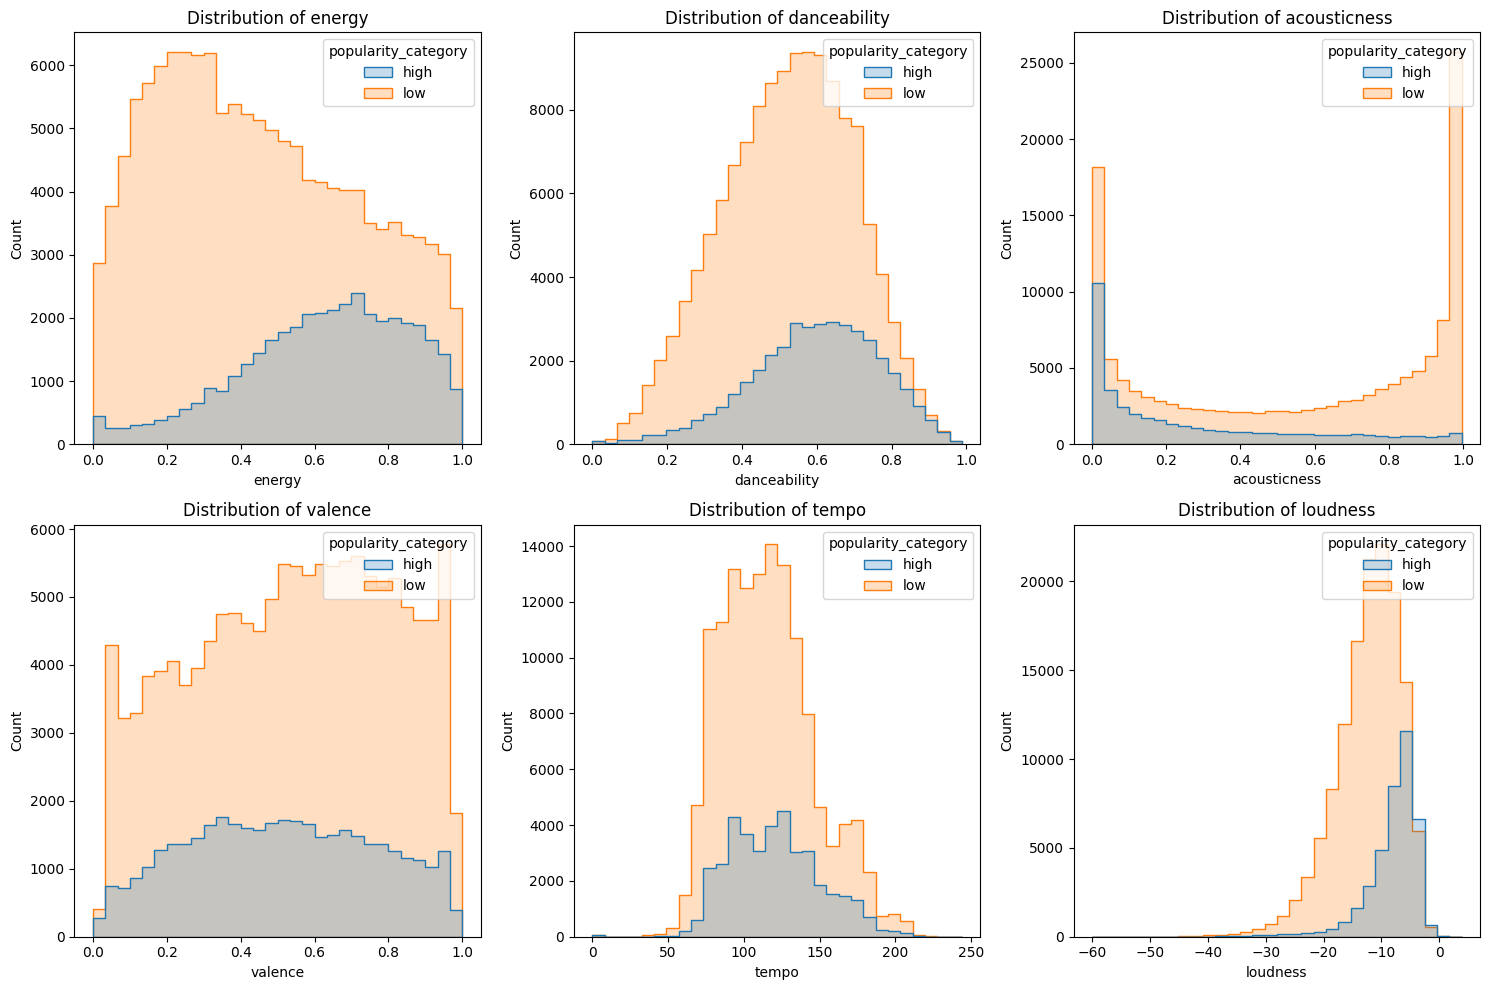

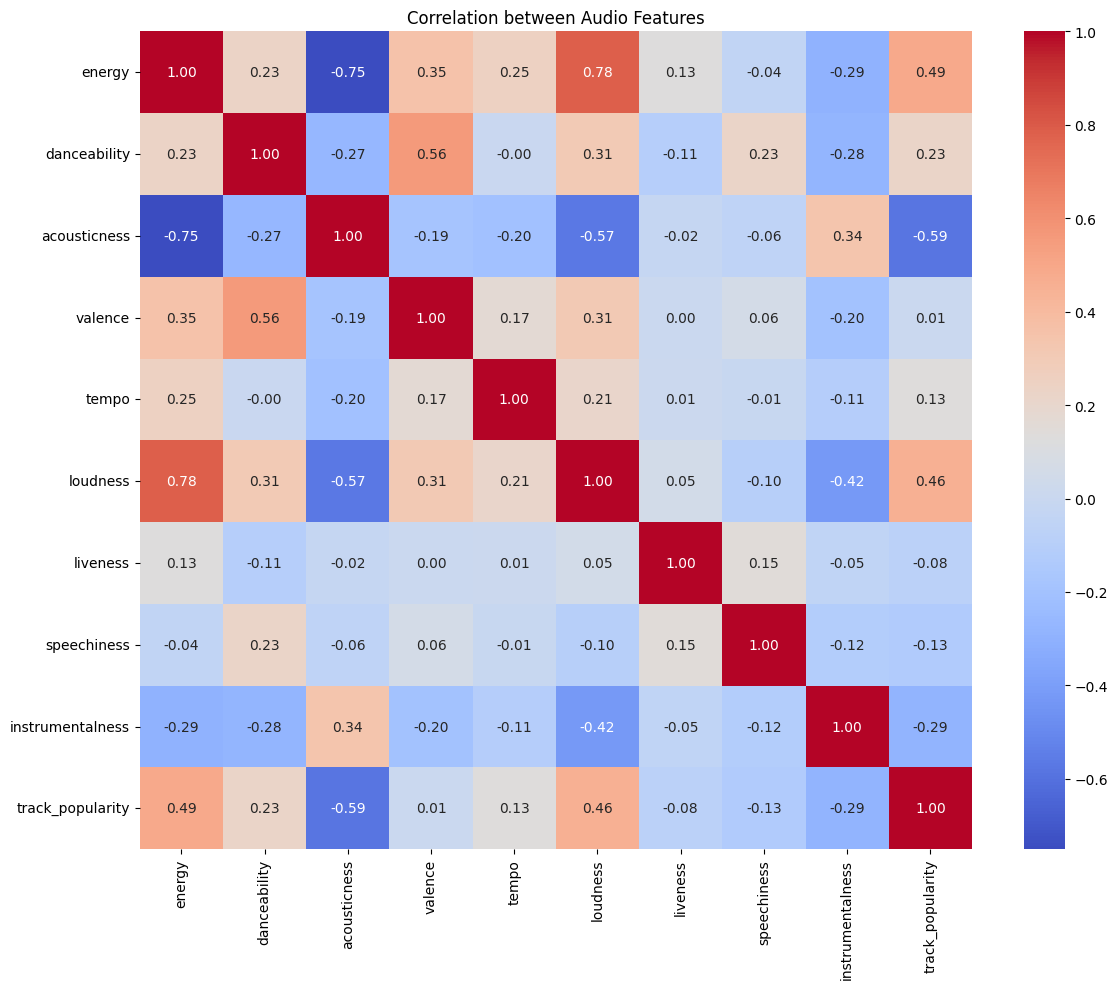

In [97]:
def visualize_features(data, audio_features):
    plt.figure(figsize=(15, 10))
    
    features_to_plot = ['energy', 'danceability', 'acousticness', 'valence', 'tempo', 'loudness']
    
    for i, feature in enumerate(features_to_plot, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=data, x=feature, hue='popularity_category', element='step', bins=30)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    correlation = data[audio_features].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation between Audio Features')
    plt.tight_layout()
    plt.show()

visualize_features(spotify_data, audio_features)

In [98]:
# Prepare data for ALS by creating interaction matrices
def prepare_data_for_als(spotify_data):
    print("Preparing data for ALS model...")
    
    spotify_data = spotify_data.copy()
    
    # Ensure track_id is unique
    spotify_data['unique_id'] = spotify_data['track_id']

    # If there are duplicate track_ids, make them unique
    if spotify_data['unique_id'].duplicated().any():
        print("Found duplicate track_ids, creating unique identifiers...")
        spotify_data['unique_id'] = spotify_data['track_id'] + '_' + spotify_data.index.astype(str)
    
    # Create a mapping from track_id to index
    track_to_idx = {tid: i for i, tid in enumerate(spotify_data['unique_id'].unique())}
    idx_to_track = {i: tid for tid, i in track_to_idx.items()}
    
    # Number of tracks
    n_tracks = len(track_to_idx)
    print(f"Total number of unique tracks: {n_tracks}")
    
    
    # Normalize audio features for similarity calculation
    features_for_sim = ['energy', 'danceability', 'acousticness',  'valence',
                        'instrumentalness', 'loudness', 'liveness', 'speechiness']
    
    # Create a scaler
    scaler = MinMaxScaler()
    spotify_data[features_for_sim] = spotify_data[features_for_sim].fillna(0)
    spotify_data[features_for_sim] = scaler.fit_transform(spotify_data[features_for_sim])
    
    # Encode playlist_genre
    genre_encoder = LabelEncoder()
    spotify_data['genre_encoded'] = genre_encoder.fit_transform(spotify_data['playlist_genre'])
    
    # Encode artists
    artist_encoder = LabelEncoder()
    spotify_data['artist_encoded'] = artist_encoder.fit_transform(spotify_data['track_artist'])
    
    # Create feature vectors for each track
    feature_vectors = spotify_data[features_for_sim].values
    
    # Add track popularity as a weight factor (normalized to 0-1)
    max_popularity = spotify_data['track_popularity'].max()
    spotify_data['popularity_weight'] = spotify_data['track_popularity'] / max_popularity
    
    # Build sparse matrix for ALS
    
    from sklearn.neighbors import NearestNeighbors
    k_neighbors = min(20, n_tracks - 1)  # Get top k similar tracks for each track
    
    print(f"Computing {k_neighbors} nearest neighbors for each track...")
    
    # Create nearest neighbor model
    nn_model = NearestNeighbors(n_neighbors=k_neighbors, algorithm='auto', metric='cosine')
    nn_model.fit(feature_vectors)
    
    # Find k nearest neighbors for each track
    distances, indices = nn_model.kneighbors(feature_vectors)
    
    # Convert distances to similarities (1 - distance) for cosine similarity
    similarities = 1 - distances
    
    # Prepare data for sparse matrix (each row: track_idx, similar_track_idx, similarity_score)
    rows = []
    cols = []
    data = []
    
    # Convert track indices to original indices in our dataframe
    track_indices = np.arange(len(spotify_data))
    
    # For each track, add its similar tracks to the interaction matrix
    for i, track_idx in enumerate(track_indices):
        track_id_idx = track_to_idx[spotify_data.iloc[track_idx]['unique_id']]
        
        # Add interactions with similar tracks
        for j, sim_track_rel_idx in enumerate(indices[i]):
            # Get the index in the original dataframe
            sim_track_idx = track_indices[sim_track_rel_idx]
            sim_track_id_idx = track_to_idx[spotify_data.iloc[sim_track_idx]['unique_id']]
            
            # Skip self-interactions
            if track_id_idx == sim_track_id_idx:
                continue
                
            # Calculate interaction strength based on similarity and popularity
            # Weight by popularity of the similar track
            interaction_strength = (similarities[i, j] * 
                                   spotify_data.iloc[sim_track_idx]['popularity_weight'])
            
            # Only include if the interaction strength is significant
            if interaction_strength > 0.1:  # Threshold to keep matrix sparse
                rows.append(track_id_idx)
                cols.append(sim_track_id_idx)
                data.append(float(interaction_strength))
    
    # Create sparse matrix for ALS
    interaction_matrix = csr_matrix((data, (rows, cols)), shape=(n_tracks, n_tracks))
    
    print(f"Created interaction matrix with {len(data)} non-zero entries")
    print(f"Matrix density: {len(data) / (n_tracks * n_tracks):.6f}")
    
    return interaction_matrix, track_to_idx, idx_to_track, spotify_data

interaction_matrix, track_to_idx, idx_to_track, spotify_data_processed = prepare_data_for_als(spotify_data)

Preparing data for ALS model...
Total number of unique tracks: 173519
Computing 20 nearest neighbors for each track...
Created interaction matrix with 2532771 non-zero entries
Matrix density: 0.000084


In [99]:
# Train an ALS model
def train_als_model(interaction_matrix, factors=100, regularization=0.01, iterations=15):
    print(f"Training ALS model with {factors} factors...")
    
    # Initialize the ALS model
    model = implicit.als.AlternatingLeastSquares(
        factors=factors,
        regularization=regularization,
        iterations=iterations,
        calculate_training_loss=True,
        random_state=42
    )
    
    # Fit the model
    model.fit(interaction_matrix, show_progress=True)
    
    return model

als_model = train_als_model(interaction_matrix)

Training ALS model with 100 factors...


100%|██████████| 15/15 [00:16<00:00,  1.08s/it, loss=3.43e-5]


In [100]:
# Evaluate ALS model performance
def evaluate_als_model(model, interaction_matrix, k=10):
    from implicit.evaluation import precision_at_k, mean_average_precision_at_k
    
    train, test = implicit.evaluation.train_test_split(interaction_matrix, train_percentage=0.8, random_state=42)
    
    # precision at k
    p_at_k = precision_at_k(model, train, test, K=k, show_progress=True)
    
    # mean average precision at k
    map_at_k = mean_average_precision_at_k(model, train, test, K=k, show_progress=True)
    
    print(f"Precision@{k}: {p_at_k:.4f}")
    print(f"MAP@{k}: {map_at_k:.4f}")
    
    return p_at_k, map_at_k

precision, mean_ap = evaluate_als_model(als_model, interaction_matrix)

100%|██████████| 154427/154427 [01:40<00:00, 1531.92it/s]

Precision@10: 0.0199
MAP@10: 0.0078


In [101]:
# Function to generate song recommendations based on user favorites
def recommend_songs(model, user_favorites, all_songs, track_to_idx, idx_to_track, top_n=10):
    
    # Check if all required audio features are present in all_songs
    required_features = ['energy', 'danceability', 'acousticness', 'valence', 'tempo']
    missing_features = [f for f in required_features if f not in all_songs.columns]
    if missing_features:
        print(f"Warning: Missing required audio features: {missing_features}")
        print(f"Available columns: {all_songs.columns.tolist()[:10]}...")

    # Get user favorite songs
    favorite_songs = all_songs[all_songs['track_id'].isin(user_favorites)].copy()
    
    if len(favorite_songs) == 0:
        print("No favorite songs found in the dataset")
        return pd.DataFrame()
    
    print(f"Found {len(favorite_songs)} favorite songs")
    
    # Get indices of favorite songs in our matrix
    favorite_indices = []
    for _, row in favorite_songs.iterrows():
        track_id = row['unique_id']
        if track_id in track_to_idx:
            favorite_indices.append(track_to_idx[track_id])
    
    if not favorite_indices:
        print("Could not find any favorite songs in the model data")
        return pd.DataFrame()
    
    # Get the user factors for favorite songs (average them to create a user profile)
    user_factors = model.item_factors[favorite_indices].mean(axis=0)
    
    # Calculate scores for all songs
    scores = model.item_factors.dot(user_factors)
    
    # Get indices of top N recommendations (excluding favorites)
    all_indices = np.arange(len(scores))
    mask = np.ones(len(scores), dtype=bool)
    mask[favorite_indices] = False
    valid_indices = all_indices[mask]
    
    # Sort valid indices by score
    top_indices = valid_indices[np.argsort(-scores[valid_indices])][:top_n]
    
    # Get track IDs for recommendations
    recommended_track_ids = [idx_to_track[idx].split('_')[0] for idx in top_indices]  # Get original track_id
    
    # Get recommendation data from the dataframe
    recommendations = all_songs[all_songs['track_id'].isin(recommended_track_ids)].copy()
    
    # Add recommendation scores
    recommendations['recommendation_score'] = [scores[idx] for idx in top_indices]
    
    # Sort by recommendation score
    recommendations = recommendations.sort_values('recommendation_score', ascending=False)
    
    result_columns = ['track_name', 'track_artist', 'track_album_name', 'playlist_genre', 
                     'energy', 'danceability', 'valence', 'tempo', 'acousticness',
                     'instrumentalness', 'loudness', 'liveness', 'speechiness',
                     'recommendation_score']
    
    return recommendations[result_columns]

In [115]:
def example_recommendation():
    sample_favorites = spotify_data.sample(5)
    user_favorite_track_ids = sample_favorites['track_id'].tolist()
    
    print("User's favorite songs:")
    display_cols = ['track_name', 'track_artist', 'playlist_genre']
    print(spotify_data[spotify_data['track_id'].isin(user_favorite_track_ids)][display_cols])
    
    # Get recommendations
    recommendations = recommend_songs(
        als_model, user_favorite_track_ids, spotify_data_processed, 
        track_to_idx, idx_to_track, top_n=10
    )
    
    print("\nRecommended songs:")
    print(recommendations[['track_name', 'track_artist', 'playlist_genre', 'recommendation_score']])
    
    return recommendations, user_favorite_track_ids

example_recommendations, example_favorites = example_recommendation()

User's favorite songs:
                                         track_name        track_artist  \
26666                                    It's a Man        Betty Hutton   
73753   The Camper Velourium II: Backend of Forever  Coheed and Cambria   
102691                                 My Best Girl        George Olsen   
126204                             Get up and Dance           The Doors   
145649               Ready for Love - 2009 Remaster         Bad Company   

       playlist_genre  
26666         unknown  
73753         unknown  
102691        unknown  
126204        unknown  
145649        unknown  
Found 5 favorite songs

Recommended songs:
                              track_name        track_artist playlist_genre  \
627     Under Pressure - Remastered 2011  Queen, David Bowie           rock   
1190                           Apologize         OneRepublic          blues   
52806                               Easy      Camila Cabello        unknown   
88974        Under Pres

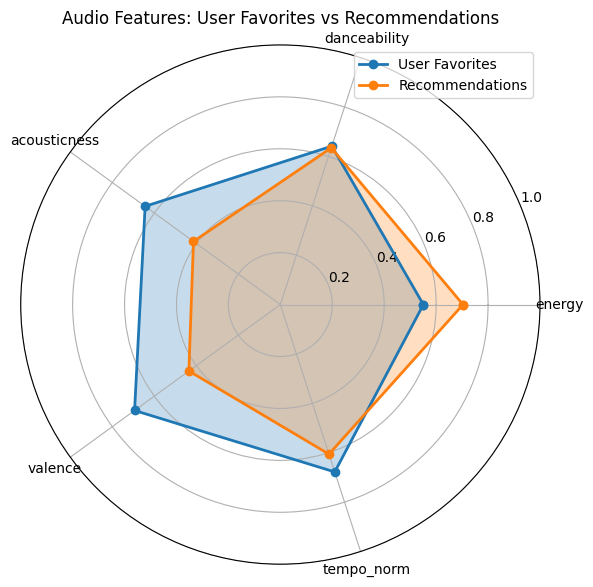

<Figure size 1200x600 with 0 Axes>

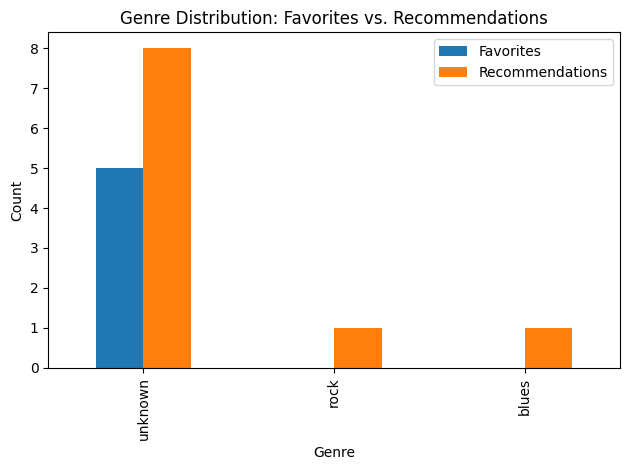

In [116]:
# Visualize the recommendations compared to user favorites
def visualize_recommendations(user_favorites, recommendations, all_songs):
    # Get user favorite songs
    favorite_songs = all_songs[all_songs['track_id'].isin(user_favorites)]
    
    # Selected features to compare
    features_to_compare = ['energy', 'danceability', 'acousticness', 'valence', 'tempo']
    
    # For better visualization, normalize tempo to [0,1] range
    favorite_songs_viz = favorite_songs.copy()
    recommendations_viz = recommendations.copy()
    
    # Check if all required columns are present
    for feature in features_to_compare:
        if feature not in favorite_songs.columns:
            print(f"Warning: {feature} not found in favorite_songs. Available columns: {favorite_songs.columns.tolist()}")
        if feature not in recommendations.columns:
            print(f"Warning: {feature} not found in recommendations. Available columns: {recommendations.columns.tolist()}")
    
    # Normalize tempo
    favorite_songs_viz['tempo_norm'] = favorite_songs['tempo'] / 200
    recommendations_viz['tempo_norm'] = recommendations['tempo'] / 200
    viz_features = [f if f != 'tempo' else 'tempo_norm' for f in features_to_compare]
    
    favorite_avg = favorite_songs_viz[viz_features].mean()
    recommendation_avg = recommendations_viz[viz_features].mean()
    
    # Radar chart
    labels = viz_features
    num_vars = len(labels)
    
    # Calculate angles for each feature
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    # Add values for both datasets
    favorite_values = favorite_avg.tolist()
    favorite_values += favorite_values[:1]
    
    recommendation_values = recommendation_avg.tolist()
    recommendation_values += recommendation_values[:1]
    
    # Create radar plot
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))
    
    # Plot favorites
    ax.plot(angles, favorite_values, 'o-', linewidth=2, label='User Favorites')
    ax.fill(angles, favorite_values, alpha=0.25)
    
    # Plot recommendations
    ax.plot(angles, recommendation_values, 'o-', linewidth=2, label='Recommendations')
    ax.fill(angles, recommendation_values, alpha=0.25)
    
    # Set labels and adjust display
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right')
    
    plt.title('Audio Features: User Favorites vs Recommendations')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # Count genres in favorites and recommendations
    favorite_genres = favorite_songs['playlist_genre'].value_counts().reindex(
        recommendations['playlist_genre'].value_counts().index, fill_value=0)
    recommended_genres = recommendations['playlist_genre'].value_counts()
    
    genre_comparison = pd.DataFrame({
        'Favorites': favorite_genres,
        'Recommendations': recommended_genres
    })
    
    genre_comparison.plot(kind='bar')
    plt.title('Genre Distribution: Favorites vs. Recommendations')
    plt.ylabel('Count')
    plt.xlabel('Genre')
    plt.tight_layout()
    plt.show()

# Visualize the example recommendations
visualize_recommendations(example_favorites, example_recommendations, spotify_data)

In [46]:
# Function to search for songs by name or artist
def search_songs(query, data, limit=15):
    """
    Search for songs by name or artist
    """
    # Convert query to lowercase for case-insensitive search
    query = query.lower()
    
    # Search in track_name and track_artist
    mask = (
        data['track_name'].str.lower().str.contains(query, na=False) |
        data['track_artist'].str.lower().str.contains(query, na=False)
    )
    
    # Get matching songs
    results = data[mask].head(limit)
    
    # Return only relevant columns
    result_columns = ['track_name', 'track_artist', 'playlist_genre', 'track_id']
    
    return results[result_columns]

# Example: Search for songs containing "love"
search_results = search_songs("love", spotify_data)
print(f"Found {len(search_results)} songs matching 'love':")
search_results[['track_name', 'track_artist', 'playlist_genre']]

Found 15 songs matching 'love':


,track_name,track_artist,playlist_genre
17,Love Somebody,Morgan Wallen,pop
18,"I Love You, I'm Sorry",Gracie Abrams,pop
31,we can't be friends (wait for your love),Ariana Grande,pop
57,I Love Rock 'N Roll,Joan Jett & the Blackhearts,rock
67,Whole Lotta Love - 1990 Remaster,Led Zeppelin,rock
130,Interstate Love Song - 2019 Remaster,Stone Temple Pilots,rock
192,Love Sosa,Chief Keef,hip-hop
226,Love Sosa,Chief Keef,hip-hop
374,Love Galore (feat. Travis Scott),"SZA, Travis Scott",r&b
376,No Love (with SZA),"Summer Walker, SZA",r&b


🎵 Welcome to the Music Recommendation System! 🎵
This system will recommend songs based on your favorites.

Options:
1. Search for songs
2. View your selected favorites
3. Get recommendations
4. Exit

Search results for '':
1. Die With A Smile by Lady Gaga, Bruno Mars (pop)
2. BIRDS OF A FEATHER by Billie Eilish (pop)
3. That’s So True by Gracie Abrams (pop)
4. Taste by Sabrina Carpenter (pop)
5. APT. by ROSÉ, Bruno Mars (pop)
6. Good Luck, Babe! by Chappell Roan (pop)
7. Diet Pepsi by Addison Rae (pop)
8. WILDFLOWER by Billie Eilish (pop)
9. Sailor Song by Gigi Perez (pop)
10. Timeless (with Playboi Carti) by The Weeknd, Playboi Carti (pop)
11. Guess featuring billie eilish by Charli xcx, Billie Eilish (pop)
12. Please Please Please by Sabrina Carpenter (pop)
13. 2 hands by Tate McRae (pop)
14. A Bar Song (Tipsy) by Shaboozey (pop)
15. HOT TO GO! by Chappell Roan (pop)

Options:
1. Search for songs
2. View your selected favorites
3. Get recommendations
4. Exit

Search results for 'humb

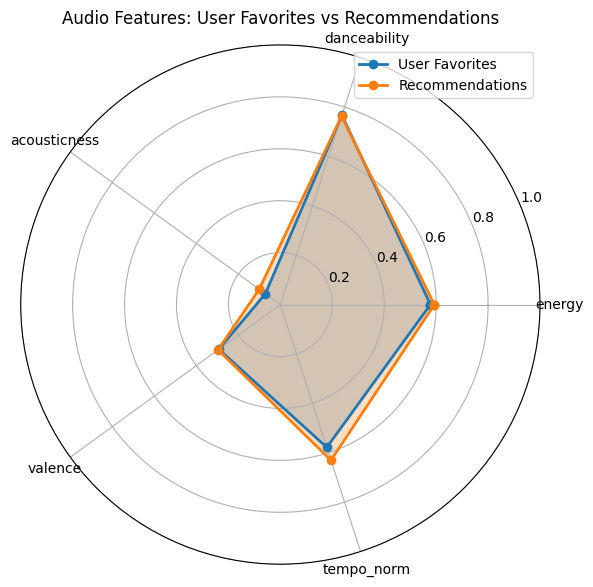

<Figure size 1200x600 with 0 Axes>

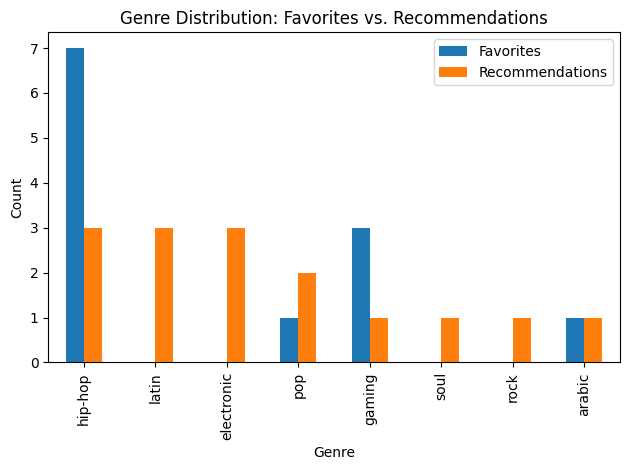


Options:
1. Search for songs
2. View your selected favorites
3. Get recommendations
4. Exit
Invalid choice. Please enter a number from 1-4.

Options:
1. Search for songs
2. View your selected favorites
3. Get recommendations
4. Exit
Invalid choice. Please enter a number from 1-4.

Options:
1. Search for songs
2. View your selected favorites
3. Get recommendations
4. Exit
Thank you for using the Music Recommendation System!


In [47]:
# Interactive music recommendation system
def music_recommendation_system():
    """
    End-to-end interactive function for the music recommendation system
    """
    print("🎵 Welcome to the Music Recommendation System! 🎵")
    print("This system will recommend songs based on your favorites.")
    
    # Initialize list to store selected track IDs
    selected_track_ids = []
    
    while True:
        print("\nOptions:")
        print("1. Search for songs")
        print("2. View your selected favorites")
        print("3. Get recommendations")
        print("4. Exit")
        
        choice = input("Enter your choice (1-4): ")
        
        if choice == '1':
            # Search for songs
            search_query = input("\nEnter song name or artist to search: ")
            search_results = search_songs(search_query, spotify_data)
            
            print(f"\nSearch results for '{search_query}':")
            if len(search_results) > 0:
                for i, (_, row) in enumerate(search_results.iterrows(), 1):
                    print(f"{i}. {row['track_name']} by {row['track_artist']} ({row['playlist_genre']})")
                
                # Let user select songs
                selection = input("\nEnter the numbers of songs to add to favorites (comma-separated), or press Enter to skip: ")
                if selection.strip():
                    try:
                        selected_indices = [int(x.strip()) - 1 for x in selection.split(',')]
                        for idx in selected_indices:
                            if 0 <= idx < len(search_results):
                                track_id = search_results.iloc[idx]['track_id']
                                if track_id not in selected_track_ids:
                                    selected_track_ids.append(track_id)
                                    print(f"Added: {search_results.iloc[idx]['track_name']} by {search_results.iloc[idx]['track_artist']}")
                    except ValueError:
                        print("Please enter valid numbers separated by commas.")
            else:
                print("No results found.")
        
        elif choice == '2':
            # View selected songs
            if selected_track_ids:
                print("\nYour selected favorite songs:")
                favorite_songs = spotify_data[spotify_data['track_id'].isin(selected_track_ids)]
                for i, (_, row) in enumerate(favorite_songs.iterrows(), 1):
                    print(f"{i}. {row['track_name']} by {row['track_artist']} ({row['playlist_genre']})")
            else:
                print("No songs selected yet. Use option 1 to search and add favorites.")
        
        elif choice == '3':
            # Get recommendations
            if selected_track_ids:
                print("\nGenerating recommendations based on your favorites...")
                recommendations = recommend_songs(
                    als_model, selected_track_ids, spotify_data_processed, 
                    track_to_idx, idx_to_track, top_n=15
                )
                
                print("\nRecommended songs:")
                for i, (_, row) in enumerate(recommendations.iterrows(), 1):
                    print(f"{i}. {row['track_name']} by {row['track_artist']} ({row['playlist_genre']})")
                
                # Visualize recommendations
                visualize_recommendations(selected_track_ids, recommendations, spotify_data)
            else:
                print("Please select some favorite songs first using option 1.")
        
        elif choice == '4':
            # Exit
            print("Thank you for using the Music Recommendation System!")
            break
        
        else:
            print("Invalid choice. Please enter a number from 1-4.")

# Uncomment the line below to run the interactive system
music_recommendation_system()

In [119]:
def save_model(model, model_dir):
    os.makedirs(model_dir, exist_ok=True)
    
    # Save the model factors
    np.save(os.path.join(model_dir, 'user_factors.npy'), model.user_factors)
    np.save(os.path.join(model_dir, 'item_factors.npy'), model.item_factors)
    
    # Save mappings
    with open(os.path.join(model_dir, 'track_to_idx.pkl'), 'wb') as f:
        pickle.dump(track_to_idx, f)
    
    with open(os.path.join(model_dir, 'idx_to_track.pkl'), 'wb') as f:
        pickle.dump(idx_to_track, f)
    
    # Save model hyperparameters
    model_params = {
        'factors': model.factors,
        'regularization': model.regularization,
        'iterations': model.iterations
    }
    
    with open(os.path.join(model_dir, 'model_params.pkl'), 'wb') as f:
        pickle.dump(model_params, f)
    
    print(f"Model and preprocessing components saved to {model_dir}")

def load_model(model_dir):
    with open(os.path.join(model_dir, 'model_params.pkl'), 'rb') as f:
        model_params = pickle.load(f)
    
    model = implicit.als.AlternatingLeastSquares(
        factors=model_params['factors'],
        regularization=model_params['regularization'],
        iterations=model_params['iterations']
    )
    
    # Load factors
    model.user_factors = np.load(os.path.join(model_dir, 'user_factors.npy'))
    model.item_factors = np.load(os.path.join(model_dir, 'item_factors.npy'))
    
    # Load mappings
    with open(os.path.join(model_dir, 'track_to_idx.pkl'), 'rb') as f:
        track_to_idx = pickle.load(f)
    
    with open(os.path.join(model_dir, 'idx_to_track.pkl'), 'rb') as f:
        idx_to_track = pickle.load(f)
    
    print(f"Model loaded successfully from {model_dir}")
    return model, track_to_idx, idx_to_track

# Save model
model_dir = "./saved_als_model"
save_model(als_model, model_dir)

# Uncomment to load the saved model
# loaded_model, loaded_track_to_idx, loaded_idx_to_track = load_model(model_dir)

Model and preprocessing components saved to ./saved_als_model
